In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe


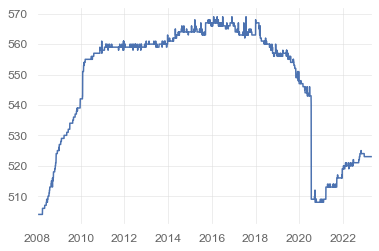

In [8]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

In [3]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities

shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)

book_value_share = book_value/ shares
adj_close = market_data['close'].unstack().reindex_like(P).astype(float)
PB_ratio = adj_close/book_value_share

C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2950160959.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(15).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2950160959.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe      1.1
Turnover    0.9
biais       1.4
dtype: float64

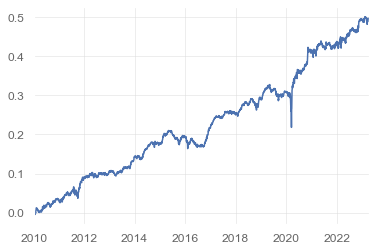

In [4]:
signal = PB_ratio[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(15).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

# Leverage

In [5]:
ltDebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stDebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
debt_assets = ((stDebt+ltDebt)/ totalAssets).reindex_like(P).ffill().astype(float)


# ROIC

In [9]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)

roic = ebit/(totalAssets - totalCurrentAssets)
roic = roic.groupby(GICS['gicind'],axis=1).apply(center)

C:\Users\marti\AppData\Local\Temp\ipykernel_105316\760679159.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  roic = roic.groupby(GICS['gicind'],axis=1).apply(center)


C:\Users\marti\AppData\Local\Temp\ipykernel_105316\820946762.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\820946762.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.5
Turnover    0.0
biais       1.1
dtype: float64

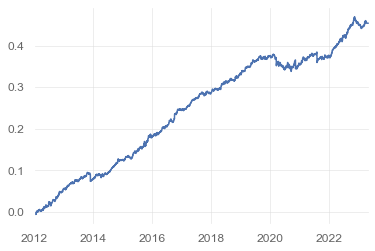

In [11]:
signal = roic[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl_roic = (signal[P].shift()*R).sum(1).loc['2012':]
sr = sharpe(pnl_roic)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl_roic.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_roic.mean()*1e4}).round(1)

C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2113150946.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  EM = EM.groupby(GICS['gicsubind'],axis=1).apply(center)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2113150946.py:13: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2113150946.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In 

Sharpe      0.9
Turnover    0.1
biais       0.6
dtype: float64

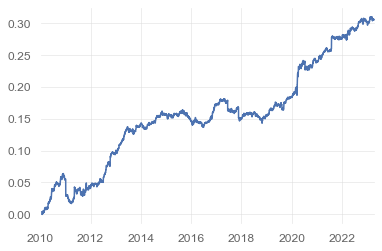

In [12]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)

EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)

EM = EV / ebitda
EM = EM.groupby(GICS['gicsubind'],axis=1).apply(center)
# EM = EM.sub(EM.mean(1),0).div(EM.std(1),0)
signal = EM[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.1] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl_EM = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl_EM)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl_EM.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_EM.mean()*1e4}).round(1)


In [107]:
pnl_roic = pd.DataFrame(pnl_roic,columns =['STRAT ROIC']).loc['2010':]
pnl_EM = pd.DataFrame(pnl_EM,columns =['STRAT EM']).loc['2010':]
pnl_roic

,STRAT ROIC
2010-01-01,0.000000
2010-01-04,-0.000510
2010-01-05,-0.000223
2010-01-06,-0.000104
2010-01-07,-0.000463
...,...
2023-03-31,-0.000495
2023-04-03,0.000468
2023-04-04,0.000283
2023-04-05,0.000593


In [108]:
stock = qs.utils.download_returns('SPY')
pnl_EM.index = pd.to_datetime(pnl_EM.index)
pnl_EM.name = 'Close'
qs.reports.html(pnl_EM['STRAT EM'],pnl_roic['STRAT ROIC'])

c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


# Net debt to ebitda ratio

In [13]:
netDebt = balance_sheet['netDebt'].unstack().reindex_like(P).ffill().astype(float)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)

ratio = netDebt/ebitda


C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2316136915.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\2316136915.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      0.9
Turnover    0.0
biais       0.7
dtype: float64

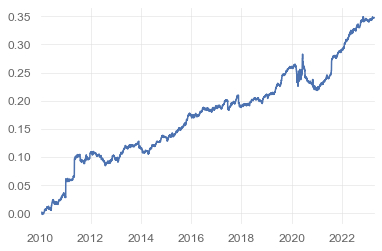

In [14]:

signal = ratio[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(365).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.1] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl_ratio = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl_ratio)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl_ratio.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_ratio.mean()*1e4}).round(1)


# Assets turnover ratio

In [15]:
totalRevenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)

turnover_ratio = (totalRevenue/totalAssets)
turnover_ratio = turnover_ratio.groupby(GICS['gicsect'],axis=1).apply(center)

C:\Users\marti\AppData\Local\Temp\ipykernel_105316\673090168.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  turnover_ratio = turnover_ratio.groupby(GICS['gicsect'],axis=1).apply(center)


C:\Users\marti\AppData\Local\Temp\ipykernel_105316\1672481971.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_105316\1672481971.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.2
Turnover    0.1
biais       1.3
dtype: float64

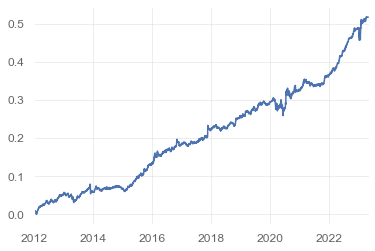

In [17]:

signal = turnover_ratio[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.7] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl_ratio = (signal[P].shift()*R).sum(1).loc['2012':]
sr = sharpe(pnl_ratio)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl_ratio.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl_ratio.mean()*1e4}).round(1)
